<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Wavefunction_Symmetry_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [19]:
# -*- coding: utf-8 -*-
"""Colab setup: Matplotlib DPI and imports."""

import math
import numpy as np
import matplotlib.pyplot as plt

# Requested: 200-dpi figures
plt.rcParams["figure.dpi"] = 200

print("Matplotlib rcParams['figure.dpi'] =", plt.rcParams["figure.dpi"])


Matplotlib rcParams['figure.dpi'] = 200.0


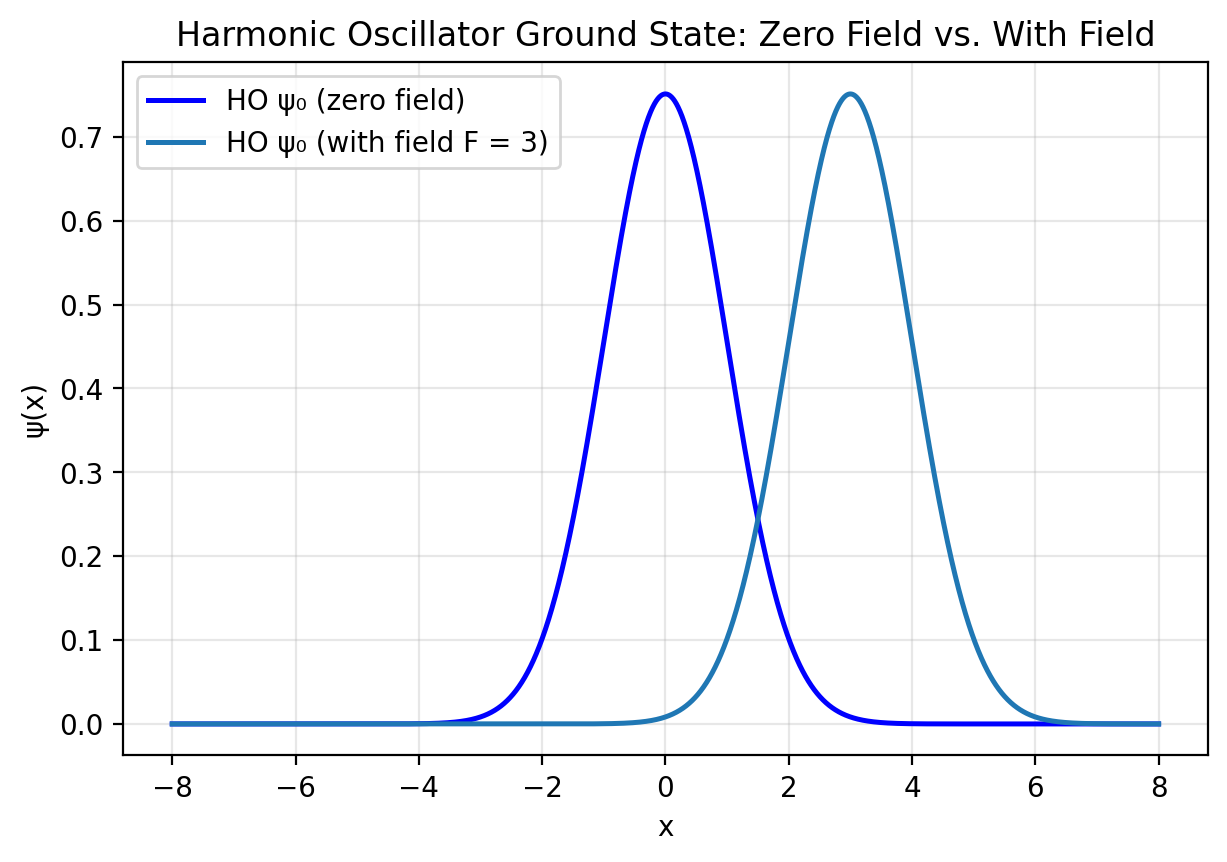

In [24]:
# -*- coding: utf-8 -*-
"""Harmonic oscillator ground-state: zero field (blue line) vs. with field (line only, no fill)."""

import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

# Ensure figures render at 200 dpi as requested
plt.rcParams["figure.dpi"] = 200


@dataclass
class HOParams:
    """Parameters for a 1D harmonic oscillator (ħ = m = 1 by default).

    Attributes:
        mass: Particle mass (m).
        omega: Angular frequency (ω).
        hbar: Reduced Planck constant (ħ).
        field: Uniform field strength F (coupled as -F x with q = +1).
        x_min: Minimum x for plotting grid.
        x_max: Maximum x for plotting grid.
        num_points: Number of x samples.
    """
    mass: float = 1.0
    omega: float = 1.0
    hbar: float = 1.0
    field: float = 3.0
    x_min: float = -8.0
    x_max: float = 8.0
    num_points: int = 4096


def ho_ground_state_wavefunction(
    x: np.ndarray, m: float, omega: float, hbar: float, x0: float
) -> np.ndarray:
    """Return the normalized HO ground-state wavefunction centered at x0."""
    alpha = m * omega / hbar
    norm = (alpha / math.pi) ** 0.25
    return norm * np.exp(-0.5 * alpha * (x - x0) ** 2)


def plot_ho_comparison(params: HOParams) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Plot ψ₀(x) at zero field (blue) and with field (line only, no fill)."""
    x = np.linspace(params.x_min, params.x_max, params.num_points, dtype=float)

    # Zero-field: centered at x0 = 0
    psi0_zero = ho_ground_state_wavefunction(x, params.mass, params.omega, params.hbar, x0=0.0)

    # With-field: displaced minimum x0 = F / (m ω²) for q = +1
    k = params.mass * (params.omega ** 2)
    x0 = params.field / k
    psi0_field = ho_ground_state_wavefunction(x, params.mass, params.omega, params.hbar, x0=x0)

    # One figure (no subplots)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Zero-field line explicitly blue (requested)
    ax.plot(x, psi0_zero, label="HO ψ₀ (zero field)", color="blue", linewidth=1.8)

    # With-field line ONLY (no fill)
    ax.plot(x, psi0_field, label=f"HO ψ₀ (with field F = {params.field:g})", linewidth=1.8)

    ax.set_title("Harmonic Oscillator Ground State: Zero Field vs. With Field")
    ax.set_xlabel("x")
    ax.set_ylabel("ψ(x)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.show()

    return x, psi0_zero, psi0_field


# ----- Control knobs and run -----
ho_params = HOParams(field=3.0)
_ = plot_ho_comparison(ho_params)


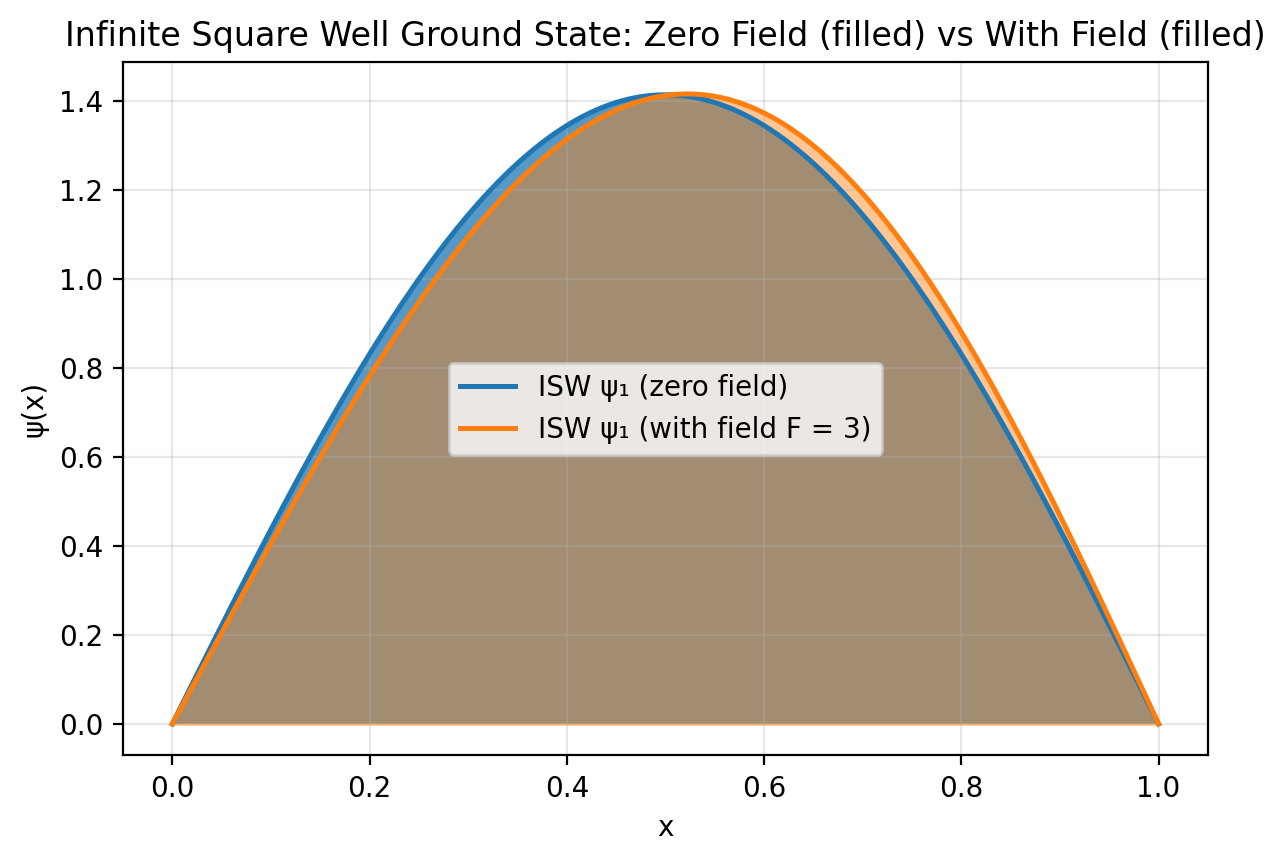

In [30]:
# -*- coding: utf-8 -*-
"""Infinite square well (ISW): zero-field (filled+outlined) vs with-field (filled)."""

import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

# Keep figures crisp
plt.rcParams["figure.dpi"] = 200


@dataclass
class ISWParams:
    """Parameters for a 1D infinite square well on 0 ≤ x ≤ L."""
    L: float = 1.0
    hbar: float = 1.0
    mass: float = 1.0
    field: float = 3.0
    n_basis: int = 80
    num_xpoints: int = 4000
    zero_fill_alpha: float = 0.75   # transparency for zero-field fill
    field_fill_alpha: float = 0.45  # transparency for with-field fill


def isw_basis_wavefunction(n: int, x: np.ndarray, L: float) -> np.ndarray:
    """Normalized zero-field ISW eigenfunction: ψₙ(x) = √(2/L) sin(nπx/L)."""
    return math.sqrt(2.0 / L) * np.sin(n * math.pi * x / L)


def build_isw_hamiltonian(params: ISWParams) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Construct and diagonalize H = H0 - F x in the sine basis (NumPy only)."""
    L = params.L
    m = params.mass
    hbar = params.hbar
    F = params.field
    nB = params.n_basis

    # Spatial grid and basis stack
    x = np.linspace(0.0, L, params.num_xpoints, dtype=float)
    psi = np.array([isw_basis_wavefunction(n, x, L) for n in range(1, nB + 1)], dtype=float)

    # Zero-field energies: Eₙ = ħ²π²n² / (2mL²)
    n_idx = np.arange(1, nB + 1, dtype=float)
    E0 = (hbar ** 2) * (math.pi ** 2) * (n_idx ** 2) / (2.0 * m * (L ** 2))

    # Field matrix V_{mn} = -F ∫ ψ_m(x) x ψ_n(x) dx using NumPy's trapezoid rule (no SciPy)
    x_times_psi = x[None, :] * psi              # (nB, Nx)
    V = np.empty((nB, nB), dtype=float)
    for m_idx in range(nB):
        row_block = psi[m_idx, :] * x_times_psi  # (nB, Nx)
        V[m_idx, :] = -F * np.trapezoid(row_block, x, axis=1)

    # Diagonalize
    H = np.diag(E0) + V
    evals, evecs = np.linalg.eigh(H)
    return evals, evecs, x


def reconstruct_state_from_basis(coeffs: np.ndarray, x: np.ndarray, L: float) -> np.ndarray:
    """Reconstruct and normalize ψ(x) = Σ cₙ ψₙ(x)."""
    nB = coeffs.size
    n_idx = np.arange(1, nB + 1, dtype=int)
    psi_stack = np.array([isw_basis_wavefunction(n, x, L) for n in n_idx], dtype=float)
    psi = coeffs @ psi_stack
    norm = math.sqrt(np.trapezoid(np.abs(psi) ** 2, x))
    return psi / norm if norm > 0 else psi


def plot_isw_comparison(params: ISWParams) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Plot ψ₁(x): zero-field (filled+outlined) vs with-field (line+filled)."""
    x = np.linspace(0.0, params.L, params.num_xpoints, dtype=float)

    # Analytic zero-field ground state (n = 1)
    psi0_zero = isw_basis_wavefunction(1, x, params.L)

    # With-field ground state by diagonalization
    evals, evecs, x_grid = build_isw_hamiltonian(params)
    assert np.allclose(x, x_grid), "Internal grid mismatch."
    coeffs0 = evecs[:, 0]
    psi0_field = reconstruct_state_from_basis(coeffs0, x, params.L)

    # Align sign for visual comparison
    sgn = np.sign(np.trapezoid(psi0_zero * psi0_field, x))
    psi0_field = psi0_field if sgn == 0 else sgn * psi0_field

    # Plot (single figure)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Zero-field: fill + solid outline (ADD LABEL HERE)
    ax.fill_between(x, 0.0, psi0_zero, alpha=params.zero_fill_alpha)
    ax.plot(x, psi0_zero, linewidth=1.8, label="ISW ψ₁ (zero field)")

    # With-field: line + fill using line color
    line_field, = ax.plot(
        x, psi0_field, linewidth=1.8, label=f"ISW ψ₁ (with field F = {params.field:g})"
    )
    ax.fill_between(x, 0.0, psi0_field, alpha=params.field_fill_alpha, color=line_field.get_color())

    ax.set_title("Infinite Square Well Ground State: Zero Field (filled) vs With Field (filled)")
    ax.set_xlabel("x")
    ax.set_ylabel("ψ(x)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.show()

    return x, psi0_zero, psi0_field


# ---- Control knobs and run ----
isw_params = ISWParams(
    L=1.0,
    hbar=1.0,
    mass=1.0,
    field=3.0,
    n_basis=80,
    num_xpoints=4000,
    zero_fill_alpha=0.75,
    field_fill_alpha=0.45,
)
_ = plot_isw_comparison(isw_params)